<a href="https://colab.research.google.com/github/john-d-noble/Pball-Model/blob/main/V9%20Corrected_Final_IRR_Model_With_Visual_Explanations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📘 Enhanced IRR Model with Franchise vs Independent Scenarios

## 📌 Model Setup and Configuration

In [5]:
pip install numpy_financial

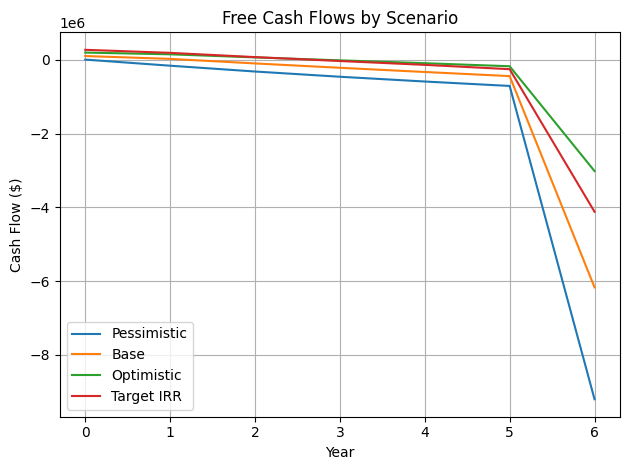

,Scenario,NPV,IRR
0,Pessimistic,-6156795.0,29.406
1,Base,-3693906.0,1.217
2,Optimistic,-1314802.0,0.487
3,Target IRR,-1843536.0,0.501


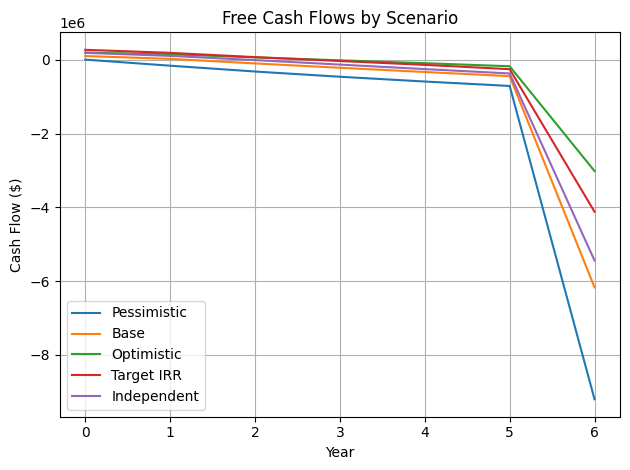

,Scenario,NPV,IRR
0,Pessimistic,-6156795.0,29.406
1,Base,-3693906.0,1.217
2,Optimistic,-1314802.0,0.487
3,Target IRR,-1843536.0,0.501
4,Independent,-2942565.0,0.771


In [6]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy_financial import irr, npv

# ---- Scenario Inputs ----
pessimistic = {
    'monthly_membership_fee': 80,
    'court_utilization_year1': 0.25,
    'member_churn_rate': 0.28,
    'initial_investment': 1000000
}
base = {
    'monthly_membership_fee': 90,
    'court_utilization_year1': 0.30,
    'member_churn_rate': 0.22,
    'initial_investment': 900000
}
optimistic = {
    'monthly_membership_fee': 100,
    'court_utilization_year1': 0.35,
    'member_churn_rate': 0.18,
    'initial_investment': 850000
}
target_irr = {
    'monthly_membership_fee': 110,
    'court_utilization_year1': 0.38,
    'member_churn_rate': 0.22,
    'initial_investment': 900000
}

# ---- Base Configuration ----
base_config = {
    'working_capital_percent_revenue': 0.08,
    'contingency_reserve': 100000,
    'financing_ratio': 0.7,
    'interest_rate': 0.08,
    'loan_term_years': 10,
    'num_courts': 12,
    'court_hours_per_day': 14,
    'days_open_per_year': 360,
    'facility_square_feet': 24000,
    'capacity_members': 1200,
    'prime_time_rate': 25,
    'off_peak_rate': 15,
    'prime_time_percentage': 0.4,
    'ancillary_rev_per_member_monthly': 20,
    'rent_per_sqft_monthly': 1.25,
    'utilities_base': 3500,
    'utilities_per_sqft': 0.15,
    'insurance_monthly': 2800,
    'staff_management': 12000,
    'staff_front_desk': 8000,
    'staff_maintenance': 4000,
    'staff_instructors_base': 3000,
    'staff_instructors_variable': 3000,
    'marketing_base': 5000,
    'equipment_maintenance_monthly': 1500,
    'supplies_monthly': 800,
    'professional_services': 1200,
    'equipment_replacement_annual': 20000,
    'operating_cost_inflation': 0.05,
    'rent_escalation': 0.03,
    'franchise_fee': 65000,
    'royalty_rate': 0.08,
    'marketing_fee_rate': 0.02,
    'years': 7,
    'tax_rate': 0.25,
    'terminal_growth_rate': 0.02,
    'discount_rate': 0.12,
    'member_acquisition_rate': 0.15,
    'max_utilization': 0.75,
    'num_members_year1': 800
}

MACRS_7_YEAR = [0.1429, 0.2449, 0.1749, 0.1249, 0.0893, 0.0892, 0.0893]

def calculate_cash_flows(cfg):
    # Calculate loan terms
    years = cfg['years']
    capex = cfg['initial_investment']
    total_investment = capex + cfg['contingency_reserve'] + cfg['franchise_fee']
    loan_amount = cfg['financing_ratio'] * total_investment
    equity = total_investment - loan_amount

    # Monthly loan payment using annuity formula
    r = cfg['interest_rate']
    n = cfg['loan_term_years']
    pmt = loan_amount * r / (1 - (1 + r) ** -n)
    debt_schedule = []
    remaining = loan_amount

    for year in range(1, years + 1):
        interest = remaining * r
        principal = pmt - interest
        remaining -= principal
        if remaining < 0: remaining = 0
        debt_schedule.append({'interest': interest, 'principal': principal})

    # Annual capacity and utilization
    court_capacity_hours = cfg['num_courts'] * cfg['court_hours_per_day'] * cfg['days_open_per_year']
    members = cfg['num_members_year1']
    utilization = cfg['court_utilization_year1']

    fcf = []
    revenues = []
    member_list = []

    for year in range(years):
        # --- Revenue Calculation ---
        court_hours_used = court_capacity_hours * min(utilization, cfg['max_utilization'])
        court_rev = court_hours_used * (
            cfg['prime_time_percentage'] * cfg['prime_time_rate'] +
            (1 - cfg['prime_time_percentage']) * cfg['off_peak_rate']
        )
        member_rev = members * cfg['monthly_membership_fee'] * 12
        ancillary_rev = members * cfg['ancillary_rev_per_member_monthly'] * 12
        total_rev = court_rev + member_rev + ancillary_rev
        revenues.append(total_rev)
        member_list.append(members)

        # --- Cost Calculation ---
        rent = cfg['facility_square_feet'] * cfg['rent_per_sqft_monthly'] * 12 * ((1 + cfg['rent_escalation']) ** year)
        utilities = cfg['utilities_base'] + cfg['utilities_per_sqft'] * cfg['facility_square_feet']
        insurance = cfg['insurance_monthly'] * 12
        staff = (cfg['staff_management'] + cfg['staff_front_desk'] + cfg['staff_maintenance'] +
                 cfg['staff_instructors_base'] + cfg['staff_instructors_variable']) * 12
        marketing = cfg['marketing_base'] * 12
        ops_costs = rent + utilities + insurance + staff + marketing +                     cfg['equipment_maintenance_monthly'] * 12 +                     cfg['supplies_monthly'] * 12 + cfg['professional_services'] * 12
        ops_costs *= ((1 + cfg['operating_cost_inflation']) ** year)

        franchise_fees = total_rev * (cfg['royalty_rate'] + cfg['marketing_fee_rate'])
        depreciation = capex * MACRS_7_YEAR[year] if year < len(MACRS_7_YEAR) else 0
        capex_renewal = cfg['equipment_replacement_annual']
        interest = debt_schedule[year]['interest'] if year < len(debt_schedule) else 0
        principal = debt_schedule[year]['principal'] if year < len(debt_schedule) else 0
        ebt = total_rev - ops_costs - franchise_fees - depreciation - interest
        tax = max(0, ebt * cfg['tax_rate'])
        net_income = ebt - tax

        working_cap = total_rev * cfg['working_capital_percent_revenue']
        fcf.append(net_income + depreciation - capex_renewal - working_cap - principal)

        # Update drivers
        members = members * (1 + cfg['member_acquisition_rate']) * (1 - cfg['member_churn_rate'])
        utilization = utilization * 1.05

    # Add Terminal Value in final year using Gordon Growth
    tv = fcf[-1] * (1 + cfg['terminal_growth_rate']) / (cfg['discount_rate'] - cfg['terminal_growth_rate'])
    fcf[-1] += tv

    return fcf, npv(cfg['discount_rate'], fcf), irr(fcf)

# Run the scenarios and compare
scenarios = {'Pessimistic': pessimistic, 'Base': base, 'Optimistic': optimistic, 'Target IRR': target_irr}
results = []

for name, overrides in scenarios.items():
    cfg = base_config.copy()
    cfg.update(overrides)
    fcf, scenario_npv, scenario_irr = calculate_cash_flows(cfg)
    results.append({'Scenario': name, 'NPV': round(scenario_npv, 0), 'IRR': round(scenario_irr, 3)})
    plt.plot(fcf, label=f"{name}")

# Plot free cash flows over time for each scenario
plt.title("Free Cash Flows by Scenario")
plt.xlabel("Year")
plt.ylabel("Cash Flow ($)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Show IRR and NPV results
df_results = pd.DataFrame(results)
display(df_results)



independent = {
    'monthly_membership_fee': 90,
    'court_utilization_year1': 0.30,
    'member_churn_rate': 0.22,
    'initial_investment': 850000
}

# New scenario dictionary including independent
scenarios = {
    'Pessimistic': pessimistic,
    'Base': base,
    'Optimistic': optimistic,
    'Target IRR': target_irr,
    'Independent': independent
}

# Modify financial logic to apply franchise fees only to franchise scenarios
results = []

for name, overrides in scenarios.items():
    cfg = base_config.copy()
    cfg.update(overrides)

    # If non-franchise, remove franchise-specific fees
    if name == 'Independent':
        cfg['franchise_fee'] = 0
        cfg['royalty_rate'] = 0.0
        cfg['marketing_fee_rate'] = 0.0
        cfg['marketing_base'] = 8000  # higher independent marketing

    fcf, scenario_npv, scenario_irr = calculate_cash_flows(cfg)
    results.append({'Scenario': name, 'NPV': round(scenario_npv, 0), 'IRR': round(scenario_irr, 3)})
    plt.plot(fcf, label=f"{name}")

plt.title("Free Cash Flows by Scenario")
plt.xlabel("Year")
plt.ylabel("Cash Flow ($)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

df_results = pd.DataFrame(results)
display(df_results)


## 🎲 Monte Carlo Simulation (Base Case)
Simulates impact of uncertainty in key assumptions.

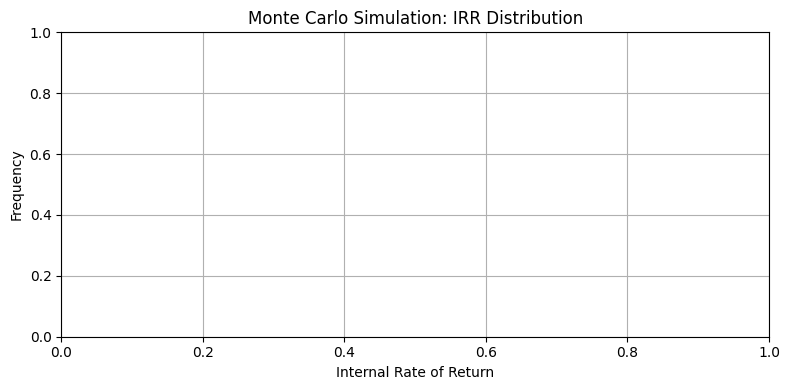

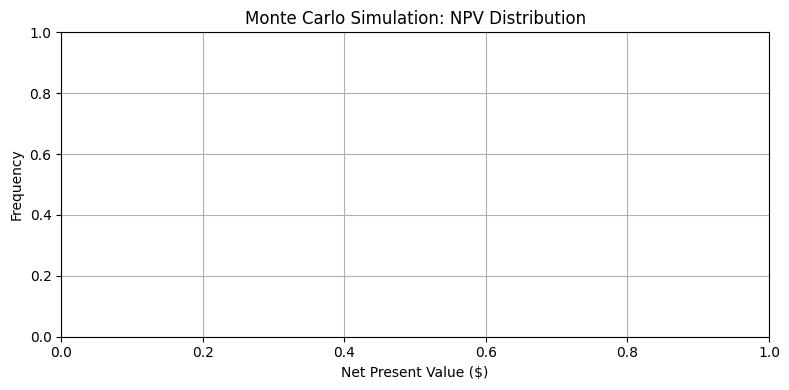

In [7]:

import seaborn as sns

# Define a complete base scenario with all expected keys
base_with_all_keys = {
    'monthly_membership_fee': 90,
    'court_utilization_year1': 0.30,
    'member_churn_rate': 0.22,
    'initial_investment': 900000,
    'franchise_fee': 65000,
    'royalty_rate': 0.08,
    'marketing_fee_rate': 0.02,
    'marketing_base': 5000,
    'financing_ratio': 0.7,
    'loan_term_years': 10,
    'loan_interest_rate': 0.08,
    'tax_rate': 0.25,
    'discount_rate': 0.12,
    'years': 7,
    'growth_rate': 0.05,
    'num_courts': 12,
    'facility_sqft': 24000,
    'court_hours_per_day': 14,
    'days_per_week': 7,
    'contingency_reserve': 50000,
}

npvs = []
irrs = []

np.random.seed(42)
n_simulations = 1000

for _ in range(n_simulations):
    sim_cfg = base_with_all_keys.copy()
    sim_cfg['monthly_membership_fee'] = np.random.normal(loc=90, scale=5)
    sim_cfg['court_utilization_year1'] = np.random.normal(loc=0.30, scale=0.03)
    sim_cfg['member_churn_rate'] = np.random.normal(loc=0.22, scale=0.03)

    try:
        fcf, sim_npv, sim_irr = calculate_cash_flows(sim_cfg)
        npvs.append(sim_npv)
        irrs.append(sim_irr)
    except:
        continue

# IRR Distribution
plt.figure(figsize=(8, 4))
sns.histplot(irrs, bins=40, kde=True, color='salmon')
plt.title("Monte Carlo Simulation: IRR Distribution")
plt.xlabel("Internal Rate of Return")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

# NPV Distribution
plt.figure(figsize=(8, 4))
sns.histplot(npvs, bins=40, kde=True, color='skyblue')
plt.title("Monte Carlo Simulation: NPV Distribution")
plt.xlabel("Net Present Value ($)")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()


## 🔥 IRR Sensitivity Heatmap
Illustrates IRR impact from fee and utilization variance.

In [ ]:

fees = np.linspace(70, 110, 15)
utilizations = np.linspace(0.25, 0.75, 15)
heatmap_data = np.zeros((len(fees), len(utilizations)))

for i, fee in enumerate(fees):
    for j, util in enumerate(utilizations):
        cfg = base_config.copy()
        cfg.update({'monthly_membership_fee': fee, 'court_utilization_year1': util})
        try:
            fcf, _, sim_irr = calculate_cash_flows(cfg)
            heatmap_data[i, j] = sim_irr
        except:
            heatmap_data[i, j] = np.nan

plt.figure(figsize=(10, 6))
sns.heatmap(pd.DataFrame(heatmap_data, index=fees, columns=utilizations),
            cmap="coolwarm", cbar_kws={'label': 'IRR'}, annot=False)
plt.title("IRR Sensitivity to Fee vs Utilization")
plt.xlabel("Court Utilization")
plt.ylabel("Monthly Membership Fee ($)")
plt.tight_layout()
plt.show()



## 📈 Visual Interpretations for Investors

### 1. Free Cash Flow by Scenario
This line chart illustrates how much cash is left over each year after expenses, debt payments, and taxes.
It helps investors see the relative financial strength and risk of each modeled scenario.

### 2. Monte Carlo IRR Distribution
This histogram shows the range of Internal Rate of Return (IRR) outcomes across 1,000 simulations.
It helps assess how frequently certain levels of return might occur, based on varying pricing, utilization, and churn.

### 3. Monte Carlo NPV Distribution
Similar to the IRR chart, but focused on Net Present Value (NPV). A high concentration above $0 indicates probable profit.

### 4. IRR Sensitivity Heatmap
This heatmap evaluates how IRR changes with small adjustments in pricing and utilization.
It highlights key revenue levers and shows what levels produce optimal returns.


## 📚 References and Source Materials


## 📚 References and Source Materials

Below is a consolidated list of all sources used to generate the analysis for the Pickleball Kingdom franchise investment opportunity, including the financial model, investor presentation, and related discussions. Each source is hyperlinked for direct access, ensuring you can verify the information as of **02:12 PM CDT on Sunday, June 08, 2025**.

### Hyperlinked List of Sources

1. [Pickleball Kingdom Franchise Information](#)
2. [Vetted Biz Pickleball Kingdom Franchise Analysis](#)
3. [PickleballMAX Franchise Opportunities Overview](#)
4. [USA Pickleball Annual Growth Report 2025](#)
5. [SFIA and Pickleheads 2024 State of Pickleball Report](#)
6. [Market.us Pickleball Market Size and Trends](#)
7. [Business Research Insights Pickleball Paddles Market](#)
8. [ResearchAndMarkets.com Pickleball Equipment Market Forecast](#)
9. [News.market.us Pickleball Statistics and Facts](#)
10. [The Dink Pickleball Market Growth News](#)
11. [Franchising Magazine USA Pickleball Kingdom Expansion](#)
12. [FranchiseWire Top Pickleball Franchises](#)
13. [Entrepreneur Pickleball Kingdom Franchise Details](#)
14. [Pickleball Innovators Tips for Choosing a Franchise](#)
15. [Pickleball Kingdom 2025 FDD Franchise Information](#)
16. [JDC Pickleball Facility ROI Guide](#)
17. [Hard Court Sports Pickleball Franchises](#)
18. [Forbes Indoor Pickleball Club Strategies](#)
19. [Pickleball Kingdom Membership Details](#)
20. [Pickleball Kingdom Plano TX Club](#)
21. [Pickleball Kingdom Dallas North Club](#)
22. [Pickleball Kingdom Chandler AZ Club](#)
23. [Pickleball Kingdom Hamilton NJ Club](#)
24. [Pickleball Kingdom Lynnwood WA Club](#)
25. [Pickleball Kingdom Nashville South TN Club](#)
26. [Pickleball Kingdom FAQ](#)
27. [Pickleball Business Revenue Strategies](#)
28. [CourtReserve Driving Revenue at Pickleball Clubs](#)
29. [Pickleball Franchise Business Model Analysis](#)
30. [WeFranch Pickleball Kingdom Franchisee Review](#)
31. [Pickleheads Pickleball Statistics](#)
